# Simulation: Gene Level and Cell Level Cosine

Loading AnnData from /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Data4NoteBook/Figure2_simu.adata...
Processing Noise: 0.6, Pattern: demo ...
Saving plot to /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure2/combined_gene_cell_cosine.pdf...


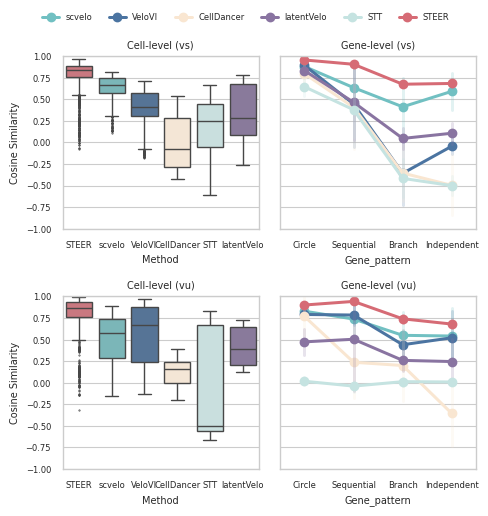

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. Configuration & File Paths
# ============================================================================
BASE_DIR = '/nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/'
RESULTS_DIR = os.path.join(BASE_DIR, 'Results_Figure2')

INPUT_ADATA_PATH = os.path.join(BASE_DIR, 'Data4NoteBook', 'Figure2_simu.adata')
OUTPUT_PLOT_PATH = os.path.join(RESULTS_DIR, 'combined_gene_cell_cosine.pdf')

# 确保输出目录存在
os.makedirs(RESULTS_DIR, exist_ok=True)

# Simulation parameters
noises = ['0.6']
pattern_list = ['demo']

# Define method-to-layer maps
METHODS_VS = {
    'STEER':      'pred_vs_norm',
    'scvelo':     'sv_vs',
    'latentVelo': 'lv_vs',
    'STT':        'stt_vs',
    'CellDancer': 'cd_vs',
    'VeloVI':     'vv_vs'
}
METHODS_VU = {
    'STEER':      'pred_vu_norm',
    'scvelo':     'sv_vu',
    'latentVelo': 'lv_vu',
    'STT':        'stt_vu',
    'CellDancer': 'cd_vu',
    'VeloVI':     'vv_vu'
}

# ============================================================================
# 2. Data Loading & Preprocessing
# ============================================================================
print(f"Loading AnnData from {INPUT_ADATA_PATH}...")
adata = sc.read_h5ad(INPUT_ADATA_PATH)

# Ensure 'Gene_pattern' is categorical
adata.var['Gene_pattern'] = adata.var['Gene_pattern'].astype('category')

# Retrieve & normalize ground-truth globally
gt_vs = adata.layers['ture_vs']  # (n_cells, n_genes)
gt_vu = adata.layers['ture_vu']  # (n_cells, n_genes)
norms = np.sqrt(gt_vu**2 + gt_vs**2)
norms = np.where(norms == 0, 1, norms)

adata.layers['ture_vs_norm'] = gt_vs / norms
adata.layers['ture_vu_norm'] = gt_vu / norms

# ============================================================================
# 3. Compute Cosine Similarities (Gene-level & Cell-level)
# ============================================================================
all_results_gene = []
all_results_cell = []

for noise in noises:
    for pattern in pattern_list:
        print(f"Processing Noise: {noise}, Pattern: {pattern} ...")
        
        # --------------------------------------------------------------------
        # PART A: Gene-level computations
        # --------------------------------------------------------------------
        ground_truth_vs_gene = adata.layers['ture_vs_norm'].T  # shape: (n_genes, n_cells)
        ground_truth_vu_gene = adata.layers['ture_vu_norm'].T  # shape: (n_genes, n_cells)

        cosine_vs_list_gene, cosine_vu_list_gene = [], []
        
        for method, layer in METHODS_VS.items():
            method_data = adata.layers[layer].T
            cosines = [
                cosine_similarity(ground_truth_vs_gene[i].reshape(1, -1), method_data[i].reshape(1, -1))[0, 0]
                for i in range(ground_truth_vs_gene.shape[0])
            ]
            cosine_vs_list_gene.append(pd.DataFrame({
                'Method': method, 'Cosine Similarity': cosines, 'Score': 'vs', 'Gene_pattern': adata.var['Gene_pattern'].values
            }))

        for method, layer in METHODS_VU.items():
            method_data = adata.layers[layer].T
            cosines = [
                cosine_similarity(ground_truth_vu_gene[i].reshape(1, -1), method_data[i].reshape(1, -1))[0, 0]
                for i in range(ground_truth_vu_gene.shape[0])
            ]
            cosine_vu_list_gene.append(pd.DataFrame({
                'Method': method, 'Cosine Similarity': cosines, 'Score': 'vu', 'Gene_pattern': adata.var['Gene_pattern'].values
            }))

        df_gene = pd.concat(cosine_vs_list_gene + cosine_vu_list_gene, ignore_index=True)
        # df_gene['Noise'] = noise
        # df_gene['Pattern'] = pattern
        all_results_gene.append(df_gene)

        # --------------------------------------------------------------------
        # PART B: Cell-level computations
        # --------------------------------------------------------------------
        norm_vs_cell = adata.layers['ture_vs_norm']  # shape: (n_cells, n_genes)
        norm_vu_cell = adata.layers['ture_vu_norm']  # shape: (n_cells, n_genes)
        
        cosine_vs_list_cell, cosine_vu_list_cell = [], []

        for method, layer in METHODS_VS.items():
            method_data = adata.layers[layer]
            cosines = [
                cosine_similarity(norm_vs_cell[i].reshape(1, -1), method_data[i].reshape(1, -1))[0, 0]
                for i in range(norm_vs_cell.shape[0])
            ]
            cosine_vs_list_cell.append(pd.DataFrame({
                'Method': method, 'Cell': np.arange(norm_vs_cell.shape[0]), 'Cosine Similarity': cosines, 'Score': 'vs'
            }))

        for method, layer in METHODS_VU.items():
            method_data = adata.layers[layer]
            cosines = [
                cosine_similarity(norm_vu_cell[i].reshape(1, -1), method_data[i].reshape(1, -1))[0, 0]
                for i in range(norm_vu_cell.shape[0])
            ]
            cosine_vu_list_cell.append(pd.DataFrame({
                'Method': method, 'Cell': np.arange(norm_vu_cell.shape[0]), 'Cosine Similarity': cosines, 'Score': 'vu'
            }))

        df_cell = pd.concat(cosine_vs_list_cell + cosine_vu_list_cell, ignore_index=True)
        # df_cell['Noise'] = noise
        # df_cell['Pattern'] = pattern
        all_results_cell.append(df_cell)

# ============================================================================
# 4. Data Aggregation & Formatting
# ============================================================================
final_df_gene = pd.concat(all_results_gene, ignore_index=True)
final_df_cell = pd.concat(all_results_cell, ignore_index=True)

# Replace numeric pattern codes with string labels
final_df_gene['Gene_pattern'] = final_df_gene['Gene_pattern'].replace({
    1: 'Sequential',
    2: 'Branch',
    3: 'Independent',
    4: 'Circle'
})

# Split by score type for plotting
df_gene_vs = final_df_gene[final_df_gene['Score'] == 'vs']
df_gene_vu = final_df_gene[final_df_gene['Score'] == 'vu']
df_cell_vs = final_df_cell[final_df_cell['Score'] == 'vs']
df_cell_vu = final_df_cell[final_df_cell['Score'] == 'vu']

# ============================================================================
# 5. Plotting (Seaborn)
# ============================================================================
plt.rcParams['pdf.fonttype'] = 42

custom_palette = {
    'scvelo':     '#71C0C2',
    'VeloVI':     '#4B74A1',
    'CellDancer': '#F9E6D1',
    'latentVelo': '#8974A1',
    'STT':        '#C5E3E1',
    'STEER':      '#D66B75'
}

sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1,
    rc={
        "axes.labelsize": 7,
        "axes.titlesize": 7,
        "legend.fontsize": 6,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6
    }
)

fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharey=True)

# ----------- 1) Cell-level vs (Top-Left) -----------
p3 = sns.boxplot(
    data=df_cell_vs,
    x='Method',
    y='Cosine Similarity',
    order=['STEER','scvelo','VeloVI','CellDancer','STT','latentVelo'],
    palette=custom_palette,
    ax=axes[0, 0],
    fliersize=0.5
)
axes[0, 0].set_ylim(-1, 1)
axes[0, 0].set_title('Cell-level (vs)', fontsize=7)

# ----------- 2) Cell-level vu (Bottom-Left) ----------
p4 = sns.boxplot(
    data=df_cell_vu,
    x='Method',
    y='Cosine Similarity',
    order=['STEER','scvelo','VeloVI','CellDancer','STT','latentVelo'],
    palette=custom_palette,
    ax=axes[1, 0],
    fliersize=0.5
)
axes[1, 0].set_ylim(-1, 1)
axes[1, 0].set_title('Cell-level (vu)', fontsize=7)

# ----------- 3) Gene-level vs (Top-Right) --------------
p1 = sns.pointplot(
    data=df_gene_vs,
    x='Gene_pattern',
    y='Cosine Similarity',
    hue='Method',
    order=['Circle','Sequential','Branch','Independent'], 
    hue_order=['scvelo','VeloVI','CellDancer','latentVelo','STT','STEER'],
    palette=custom_palette,
    errorbar='sd',
    err_kws={'alpha': 0.2},
    ax=axes[0, 1]
)
axes[0, 1].set_title('Gene-level (vs)', fontsize=7)
axes[0, 1].set_ylim(-1, 1)
axes[0, 1].legend_.remove() # Move legend out

# ----------- 4) Gene-level vu (Bottom-Right) -------------
p2 = sns.pointplot(
    data=df_gene_vu,
    x='Gene_pattern',
    y='Cosine Similarity',
    hue='Method',
    order=['Circle','Sequential','Branch','Independent'],
    hue_order=['scvelo','VeloVI','CellDancer','latentVelo','STT','STEER'],
    palette=custom_palette,
    errorbar='sd',
    err_kws={'alpha': 0.2},
    ax=axes[1, 1]
)
axes[1, 1].set_ylim(-1, 1)
axes[1, 1].set_title('Gene-level (vu)', fontsize=7)
axes[1, 1].legend_.remove() # Move legend out

# ------------------ Shared Legend ----------------------
handles, labels = p1.get_legend_handles_labels()

fig.legend(
    handles, 
    labels, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.03),  
    ncol=6,                     
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.99])

# Save Plot
print(f"Saving plot to {OUTPUT_PLOT_PATH}...")
plt.savefig(OUTPUT_PLOT_PATH, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# GE data

STEER package is imported
Loading data from: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Data4NoteBook/Figure2_GE.adata
Computing neighborhood graph and velocity graphs...
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/128 cores)
    finished (0:00:11) --> added 
    'pred_vs_norm_graph', sparse matrix with cosine correlations (adata.uns)
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/128 cores)
    finished (0:00:11) --> added 
    'pred_vs_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'pred_vs_norm_umap', embedded velocity vectors (adata.obsm)
Saved: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure2/umap_celltype_expert.pdf


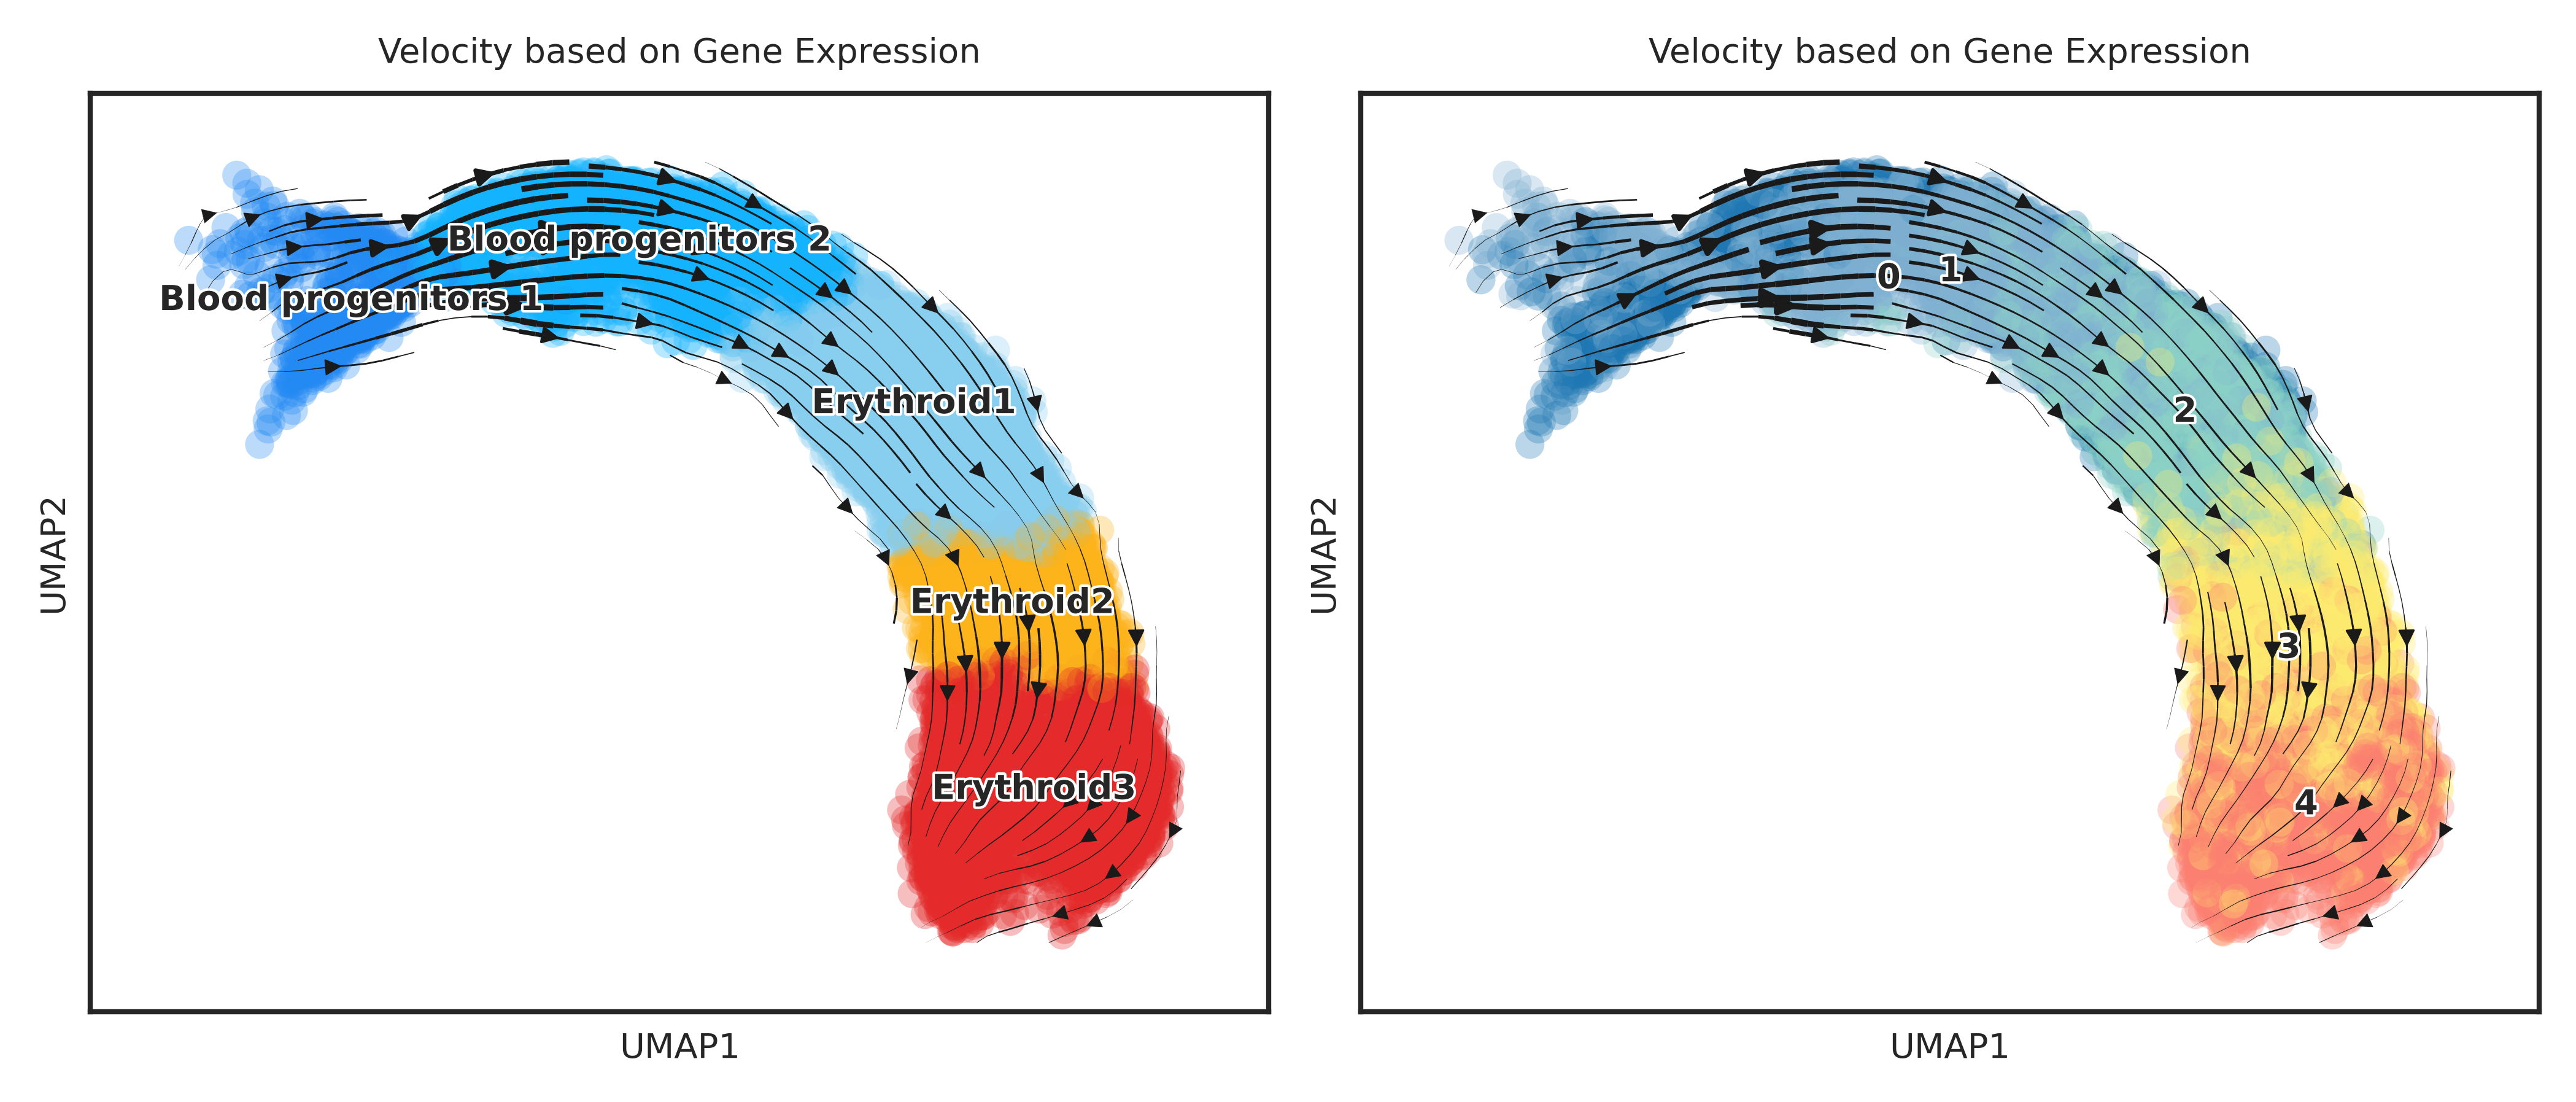

Normalizing pseudo-time and plotting...
Saved: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure2/mv.fig02.pdf


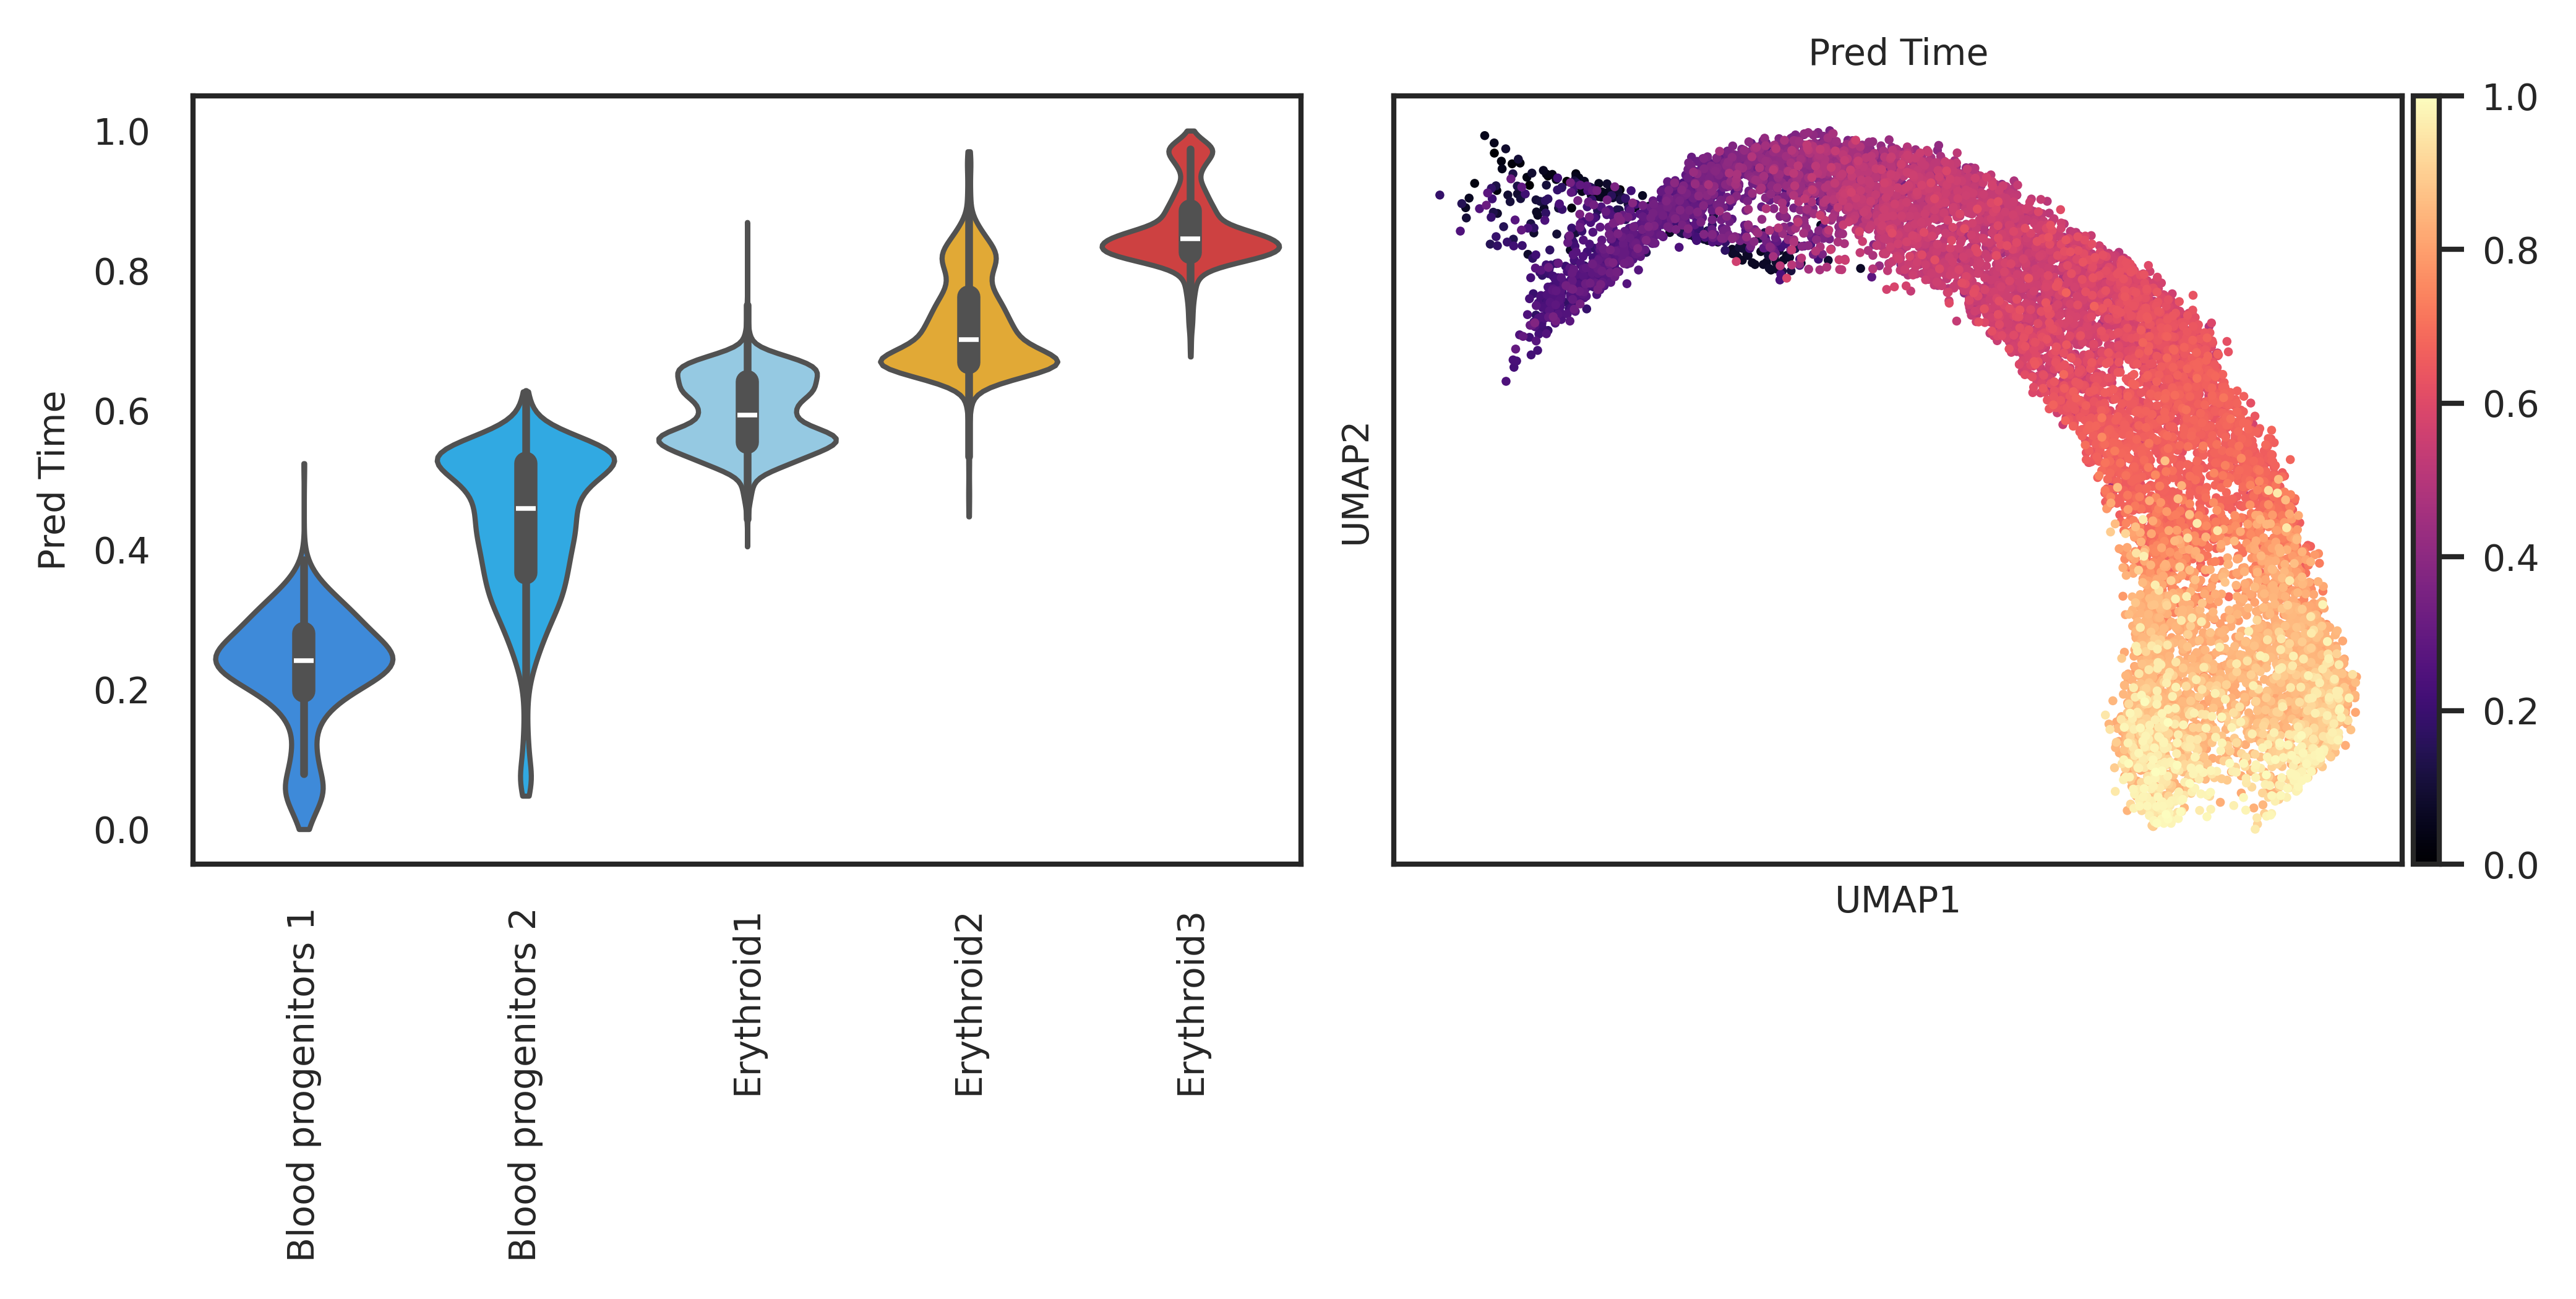

Plotting phase portraits (colored by Celltype)...
Saved phase portrait: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure2/MURK_gene_celltype.pdf


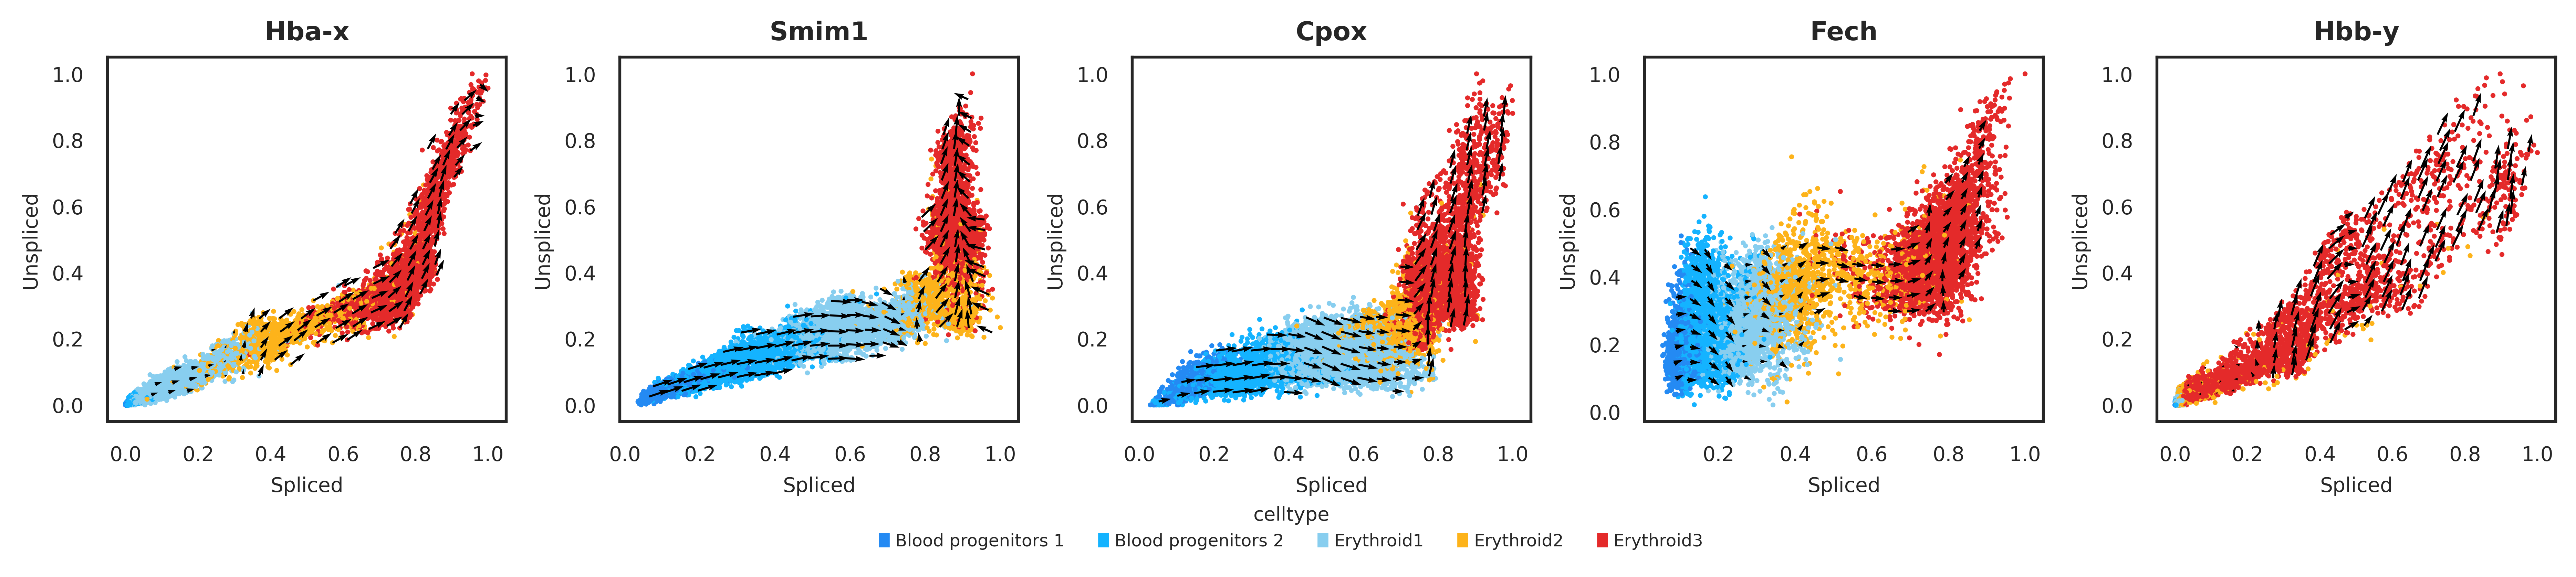

Plotting phase portraits (colored by Expert)...
Saved phase portrait: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure2/MURK_gene_expert.pdf


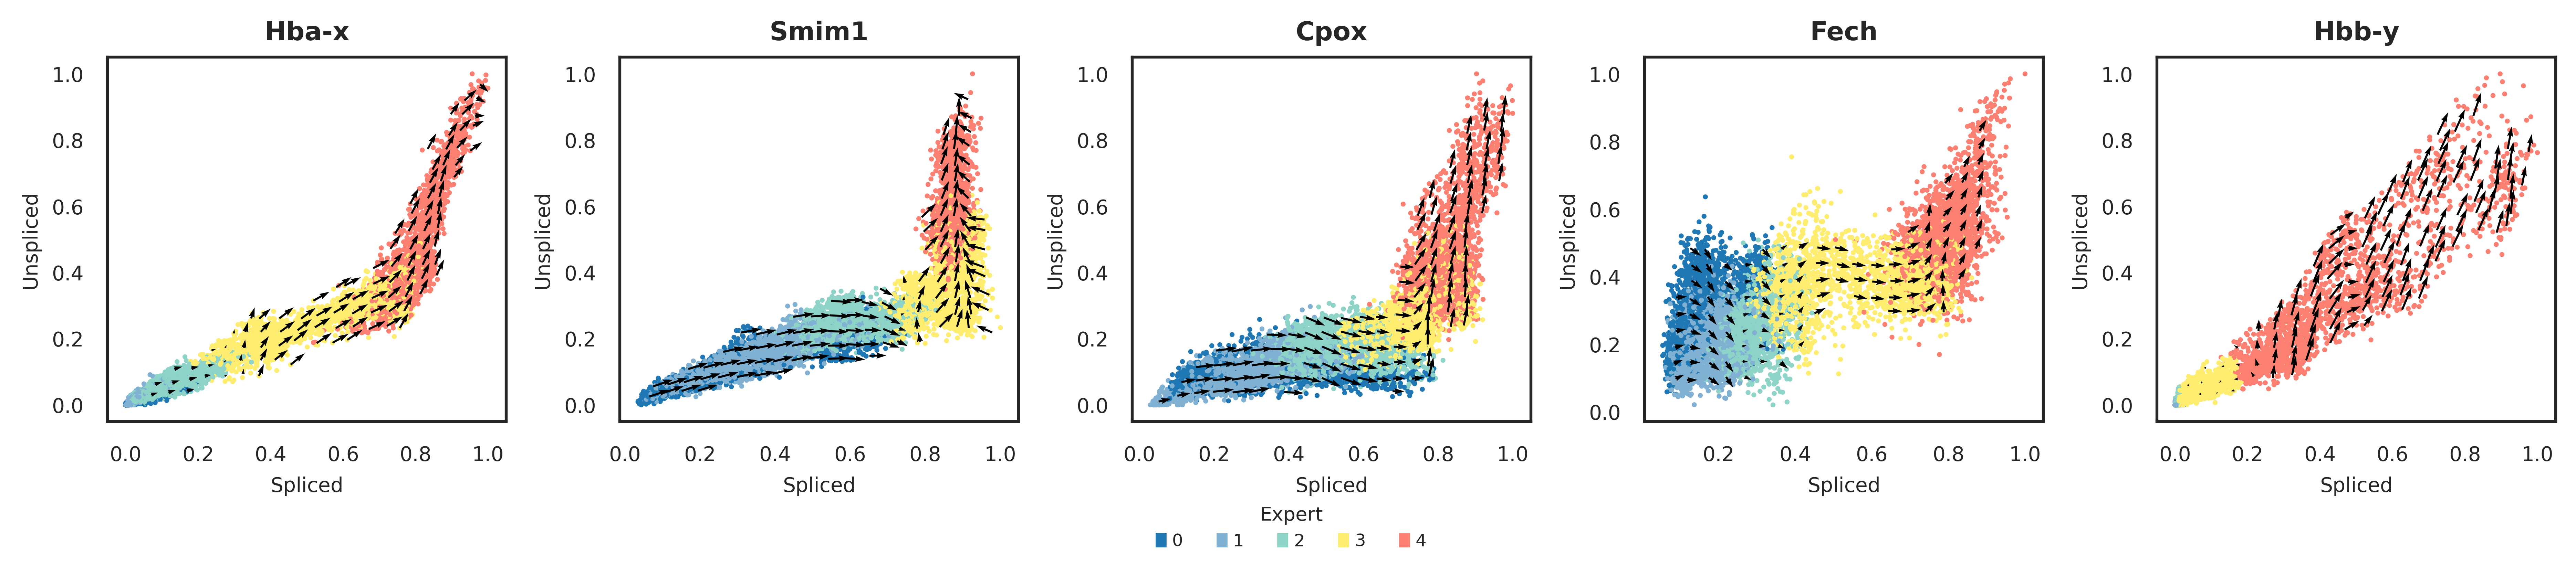

Plotting MURK genes heatmap...
saving figure to file /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure2/heatmap_MURK.png
Saved heatmap.
All tasks completed successfully.


In [2]:
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scanpy as sc
import scvelo as scv
import steer

# ============================================================================
# 1. Configuration & File Paths
# ============================================================================
BASE_DIR = '/nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures'
DATA_PATH = os.path.join(BASE_DIR, 'Data4NoteBook', 'Figure2_GE.adata')
RESULT_PATH = os.path.join(BASE_DIR, 'Results_Figure2')

if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

# ============================================================================
# 2. Global Plotting Settings (Publication Ready)
# ============================================================================
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Scanpy settings
sc.settings.figdir = RESULT_PATH
sc.settings.plot_prefix = ""
sc.settings.set_figure_params(
    dpi=300,
    fontsize=7,
    color_map='magma',
    frameon=True,
    vector_friendly=True,
    transparent=True
)

# scVelo settings
scv.settings.figdir = RESULT_PATH
scv.settings.plot_prefix = ""
scv.set_figure_params(
    style='scvelo',
    dpi=300,
    fontsize=7,
    figsize=(5, 4),
    frameon=True,
    transparent=True
)

# Seaborn settings
sns.set_theme(
    context='paper',
    style='white',
    font_scale=0.7,
    rc={
        "figure.dpi": 300,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 6,
        "lines.linewidth": 1,
        "grid.linewidth": 0.5
    }
)

# ============================================================================
# 3. Data Loading & Preprocessing
# ============================================================================
print(f"Loading data from: {DATA_PATH}")
result_adata = sc.read_h5ad(DATA_PATH)

# Re-map Expert annotations
expert_mapping = {'0': '3', '1': '4', '3': '0', '2': '1', '4': '2'}
if 'Expert' in result_adata.obs:
    result_adata.obs['Expert'] = result_adata.obs['Expert'].astype(str).replace(expert_mapping)

# Define color palettes
celltype_colors = ['#248AF3', '#14B3FF', '#88CEEF', '#FDB31A', '#E42A2A']
expert_colors = ['#1F78B4', '#80B1D3', '#8DD3C7', '#FFED6F', '#FB8072']

result_adata.uns['celltype_colors'] = celltype_colors
result_adata.uns['Expert_colors'] = expert_colors

# ============================================================================
# 4. Global Embeddings & Velocity Streams
# ============================================================================
print("Computing neighborhood graph and velocity graphs...")
sc.pp.neighbors(result_adata, use_rep='X_pca_combined', n_neighbors=30)
scv.tl.velocity_graph(result_adata, vkey='pred_vs_norm', xkey='model_Ms', basis='X_umap', show_progress_bar=False)

if 'X_umap_refine_embed' in result_adata.obsm:
    scv.tl.velocity_graph(result_adata, vkey='pred_vs_norm', xkey='model_Ms', basis='X_umap_refine_embed', show_progress_bar=False)

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
scv.pl.velocity_embedding_stream(
    result_adata, ax=axes[0], add_margin=0.1, xlabel='UMAP1', ylabel='UMAP2',
    basis='X_umap', vkey='pred_vs_norm', color='celltype',
    title='Velocity based on Gene Expression', arrow_size=0.7, linewidth=0.7, frameon=True, show=False
)
scv.pl.velocity_embedding_stream(
    result_adata, ax=axes[1], add_margin=0.1, xlabel='UMAP1', ylabel='UMAP2',
    basis='X_umap', vkey='pred_vs_norm', color='Expert',
    title='Velocity based on Gene Expression', arrow_size=0.7, linewidth=0.7, frameon=True, show=False
)
plt.tight_layout()
out_path_umap = os.path.join(RESULT_PATH, 'umap_celltype_expert.pdf')
plt.savefig(out_path_umap)
print(f"Saved: {out_path_umap}")
plt.show()

# ============================================================================
# 5. Pseudo-time Analysis
# ============================================================================
print("Normalizing pseudo-time and plotting...")
result_adata = steer.TimeNorm(result_adata)
time_order = ['Blood progenitors 1', 'Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

sc.pl.violin(
    result_adata, ax=axes[0], keys='Pred Time', stripplot=False, inner="box",
    groupby='celltype', color='celltype', rotation=90, order=time_order, show=False
)

sc.pl.embedding(
    result_adata, ax=axes[1], basis='X_umap', color='Pred Time', color_map='magma',
    frameon=True, show=False
)
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')

plt.tight_layout()
out_path_time = os.path.join(RESULT_PATH, 'mv.fig02.pdf')
plt.savefig(out_path_time)
print(f"Saved: {out_path_time}")
plt.show()

# ============================================================================
# 6. Integrated Gene Expression Phase Portrait Function
# ============================================================================
def plot_gene_expression_integrated(
    adata,
    genes,
    color_by=None,
    color_layer=None,
    path='phase_plot.pdf',
    ncols=None,
    velocity=False,
    agg='mean',
    x_key='model_Ms',
    y_key='model_Mu',
    pred_vs_key='pred_vs',
    pred_vu_key='pred_vu',
    cmap='viridis',
    point_size=30,
    arrow_scale=0.5,
    arrow_step=1,
    grid_size=20,
    sigma=3,
    lowerb=70,
    upperb=100,
    max_arrow_length=40,
    xlab='Spliced',
    ylab='Unspliced',
    random_seed=None,
    alpha=0.1,
    fontsize=7,
    rasterized=True,
    vmin=None,
    vmax=None
):
    if random_seed is not None:
        np.random.seed(random_seed)

    present_genes = [gene for gene in genes if gene in adata.var_names]
    if not present_genes:
        print("No valid genes to plot.")
        return

    n_genes = len(present_genes)
    if ncols is None:
        ncols = int(np.ceil(np.sqrt(n_genes)))
    nrows = int(np.ceil(n_genes / ncols))

    gene_indices = [adata.var_names.get_loc(gene) for gene in present_genes]
    splice_mat = adata.layers[x_key][:, gene_indices]
    unsplice_mat = adata.layers[y_key][:, gene_indices]
    
    if velocity:
        pred_vs_mat = adata.layers[pred_vs_key][:, gene_indices]
        pred_vu_mat = adata.layers[pred_vu_key][:, gene_indices]

    use_continuous_color = False
    color_data_mat = None
    colors = 'gray'
    legend_elements = None

    if color_layer and color_layer in adata.layers:
        use_continuous_color = True
        color_data_mat = adata.layers[color_layer][:, gene_indices]
    elif color_by and color_by in adata.obs:
        color_categories = adata.obs[color_by].astype('category')
        color_codes = color_categories.cat.codes
        cmap_key = f"{color_by}_colors"
        if cmap_key in adata.uns:
            color_map = adata.uns[cmap_key]
            colors = [color_map[i] for i in color_codes]
            legend_elements = [mpatches.Patch(color=c, label=l) for c, l in zip(color_map, color_categories.cat.categories)]
        else:
            colors = color_codes

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.5 * nrows))
    axs = np.array(axs).flatten() if n_genes > 1 else [axs]

    def plot_velocity_arrows_original(ax, splice_vals, unsplice_vals, pred_vs_vals, pred_vu_vals):
        x_min, x_max = splice_vals.min(), splice_vals.max()
        y_min, y_max = unsplice_vals.min(), unsplice_vals.max()

        x_bins = np.linspace(x_min, x_max, grid_size + 1)
        y_bins = np.linspace(y_min, y_max, grid_size + 1)

        x_digitized = np.clip(np.digitize(splice_vals, bins=x_bins) - 1, 0, grid_size - 1)
        y_digitized = np.clip(np.digitize(unsplice_vals, bins=y_bins) - 1, 0, grid_size - 1)

        counts, _, _ = np.histogram2d(splice_vals, unsplice_vals, bins=[x_bins, y_bins])
        density_estimate = counts.flatten()

        lower_density_threshold = np.percentile(density_estimate, lowerb)
        upper_density_threshold = np.percentile(density_estimate, upperb)
        bool_density = (density_estimate > lower_density_threshold) & (density_estimate < upper_density_threshold)
        bool_density_2d = bool_density.reshape(counts.shape)

        grid_cell_indices = x_digitized + y_digitized * grid_size
        cell_to_indices = defaultdict(list)
        for idx, grid_idx in enumerate(grid_cell_indices):
            cell_to_indices[grid_idx].append(idx)

        passing_cells = np.argwhere(bool_density_2d)
        passing_x_indices = passing_cells[:, 0]
        passing_y_indices = passing_cells[:, 1]
        grid_cell_indices_passing = passing_x_indices + passing_y_indices * grid_size

        selected_splice, selected_unsplice, selected_vs, selected_vu = [], [], [], []

        for grid_idx in grid_cell_indices_passing:
            if grid_idx in cell_to_indices:
                indices_in_cell = cell_to_indices[grid_idx]
                if len(indices_in_cell) == 0:
                    continue

                if agg == 'mean':
                    selected_splice.append(splice_vals[indices_in_cell].mean())
                    selected_unsplice.append(unsplice_vals[indices_in_cell].mean())
                    selected_vs.append(pred_vs_vals[indices_in_cell].mean())
                    selected_vu.append(pred_vu_vals[indices_in_cell].mean())
                elif agg == 'random':
                    selected_idx = np.random.choice(indices_in_cell)
                    selected_splice.append(splice_vals[selected_idx])
                    selected_unsplice.append(unsplice_vals[selected_idx])
                    selected_vs.append(pred_vs_vals[selected_idx])
                    selected_vu.append(pred_vu_vals[selected_idx])

        if len(selected_splice) == 0:
            return

        selected_splice = np.array(selected_splice)
        selected_unsplice = np.array(selected_unsplice)
        selected_vs = gaussian_filter(np.array(selected_vs), sigma=sigma)
        selected_vu = gaussian_filter(np.array(selected_vu), sigma=sigma)

        magnitude = np.hypot(selected_vs, selected_vu)
        magnitude[magnitude == 0] = 1 

        if max_arrow_length is not None:
            max_magnitude = np.percentile(magnitude, max_arrow_length)
            scale_factors = np.minimum(magnitude, max_magnitude) / magnitude
            selected_vs_scaled = selected_vs * scale_factors
            selected_vu_scaled = selected_vu * scale_factors
        else:
            selected_vs_scaled = selected_vs
            selected_vu_scaled = selected_vu

        downsample_indices = np.arange(0, len(selected_splice), arrow_step)

        ax.quiver(
            selected_splice[downsample_indices],
            selected_unsplice[downsample_indices],
            selected_vs_scaled[downsample_indices],
            selected_vu_scaled[downsample_indices],
            angles='xy', scale_units='xy', scale=arrow_scale,
            color='black', width=0.005, zorder=10
        )

    for idx, gene in enumerate(present_genes):
        ax = axs[idx]
        s_vals = splice_mat[:, idx]
        u_vals = unsplice_mat[:, idx]
        
        if use_continuous_color:
            c_vals = color_data_mat[:, idx]
            curr_vmin = np.percentile(c_vals, float(vmin[1:])) if (isinstance(vmin, str) and vmin.startswith('p')) else (vmin if vmin is not None else np.min(c_vals))
            curr_vmax = np.percentile(c_vals, float(vmax[1:])) if (isinstance(vmax, str) and vmax.startswith('p')) else (vmax if vmax is not None else np.max(c_vals))

            sc_plot = ax.scatter(s_vals, u_vals, c=c_vals, cmap=cmap, s=point_size, 
                                 alpha=alpha, edgecolors='none', rasterized=rasterized,
                                 vmin=curr_vmin, vmax=curr_vmax)
            cbar = plt.colorbar(sc_plot, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label(color_layer, fontsize=fontsize)
            cbar.ax.tick_params(labelsize=fontsize-2)
        else:
            ax.scatter(s_vals, u_vals, c=colors, cmap='viridis' if type(colors) is not list else None, 
                       s=point_size, alpha=alpha, edgecolors='none', rasterized=rasterized)

        if velocity:
            vs_vals = pred_vs_mat[:, idx]
            vu_vals = pred_vu_mat[:, idx]
            plot_velocity_arrows_original(ax, s_vals, u_vals, vs_vals, vu_vals)

        ax.set_xlabel(xlab, fontsize=fontsize)
        ax.set_ylabel(ylab, fontsize=fontsize)
        ax.set_title(f"{gene}", fontsize=fontsize+2, fontweight='bold')
        
        x_pad = (s_vals.max() - s_vals.min()) * 0.05
        y_pad = (u_vals.max() - u_vals.min()) * 0.05
        ax.set_xlim(s_vals.min() - x_pad, s_vals.max() + x_pad)
        ax.set_ylim(u_vals.min() - y_pad, u_vals.max() + y_pad)

    for j in range(len(present_genes), len(axs)):
        fig.delaxes(axs[j])

    if not use_continuous_color and legend_elements:
        fig.legend(handles=legend_elements, title=color_by, loc='upper center', 
                   bbox_to_anchor=(0.5, 0.05), ncol=len(legend_elements), frameon=False)

    plt.tight_layout()
    plt.savefig(path, dpi=300)
    print(f"Saved phase portrait: {path}")
    plt.show()

# ============================================================================
# 7. Generate Phase Portrait Plots
# ============================================================================
TB_genes = ['Hba-x', 'Smim1', 'Cpox', 'Fech', 'Hbb-y']

print("Plotting phase portraits (colored by Celltype)...")
plot_gene_expression_integrated(
    adata=result_adata,
    genes=TB_genes,
    color_by='celltype',
    path=os.path.join(RESULT_PATH, 'MURK_gene_celltype.pdf'),
    ncols=5,
    velocity=True,
    agg='mean',
    x_key='model_Ms',
    y_key='model_Mu',
    pred_vs_key='pred_vs',
    pred_vu_key='pred_vu',
    point_size=3,
    alpha=1,
    random_seed=618
)

print("Plotting phase portraits (colored by Expert)...")
plot_gene_expression_integrated(
    adata=result_adata,
    genes=TB_genes,
    color_by='Expert',
    path=os.path.join(RESULT_PATH, 'MURK_gene_expert.pdf'),
    ncols=5,
    velocity=True,
    agg='mean',
    x_key='model_Ms',
    y_key='model_Mu',
    pred_vs_key='pred_vs',
    pred_vu_key='pred_vu',
    point_size=3,
    alpha=1,
    random_seed=618
)

# print("Plotting phase portraits (colored by Continuous Layer: recon_alpha)...")
# plot_gene_expression_integrated(
#     adata=result_adata,
#     genes=TB_genes,
#     color_layer='recon_alpha',
#     path=os.path.join(RESULT_PATH, 'pred_alpha.pdf'),
#     ncols=5,
#     velocity=False, 
#     cmap='plasma',
#     point_size=3,
#     alpha=1,
#     vmin='p1',
#     vmax='p98',
#     fontsize=13,
#     rasterized=True
# )

# ============================================================================
# 8. Plot MURK Genes Heatmap
# ============================================================================
print("Plotting MURK genes heatmap...")
murk_genes = result_adata[:, result_adata.var['MURK_gene']].var_names.tolist()
if murk_genes:
    scv.pl.heatmap(
        result_adata, sortby='Pred Time', palette='magma', layer='recon_alpha',
        context='paper', col_color=['Expert', 'Pred Time'], var_names=murk_genes,
        font_scale=0.7, figsize=(4, 2), save='MURK.png', show=False
    )
    print("Saved heatmap.")
else:
    print("No MURK genes found to plot heatmap.")

print("All tasks completed successfully.")

# Spatial Simulation

Loading and merging cleaned benchmark data...
Generating Publication Figures...


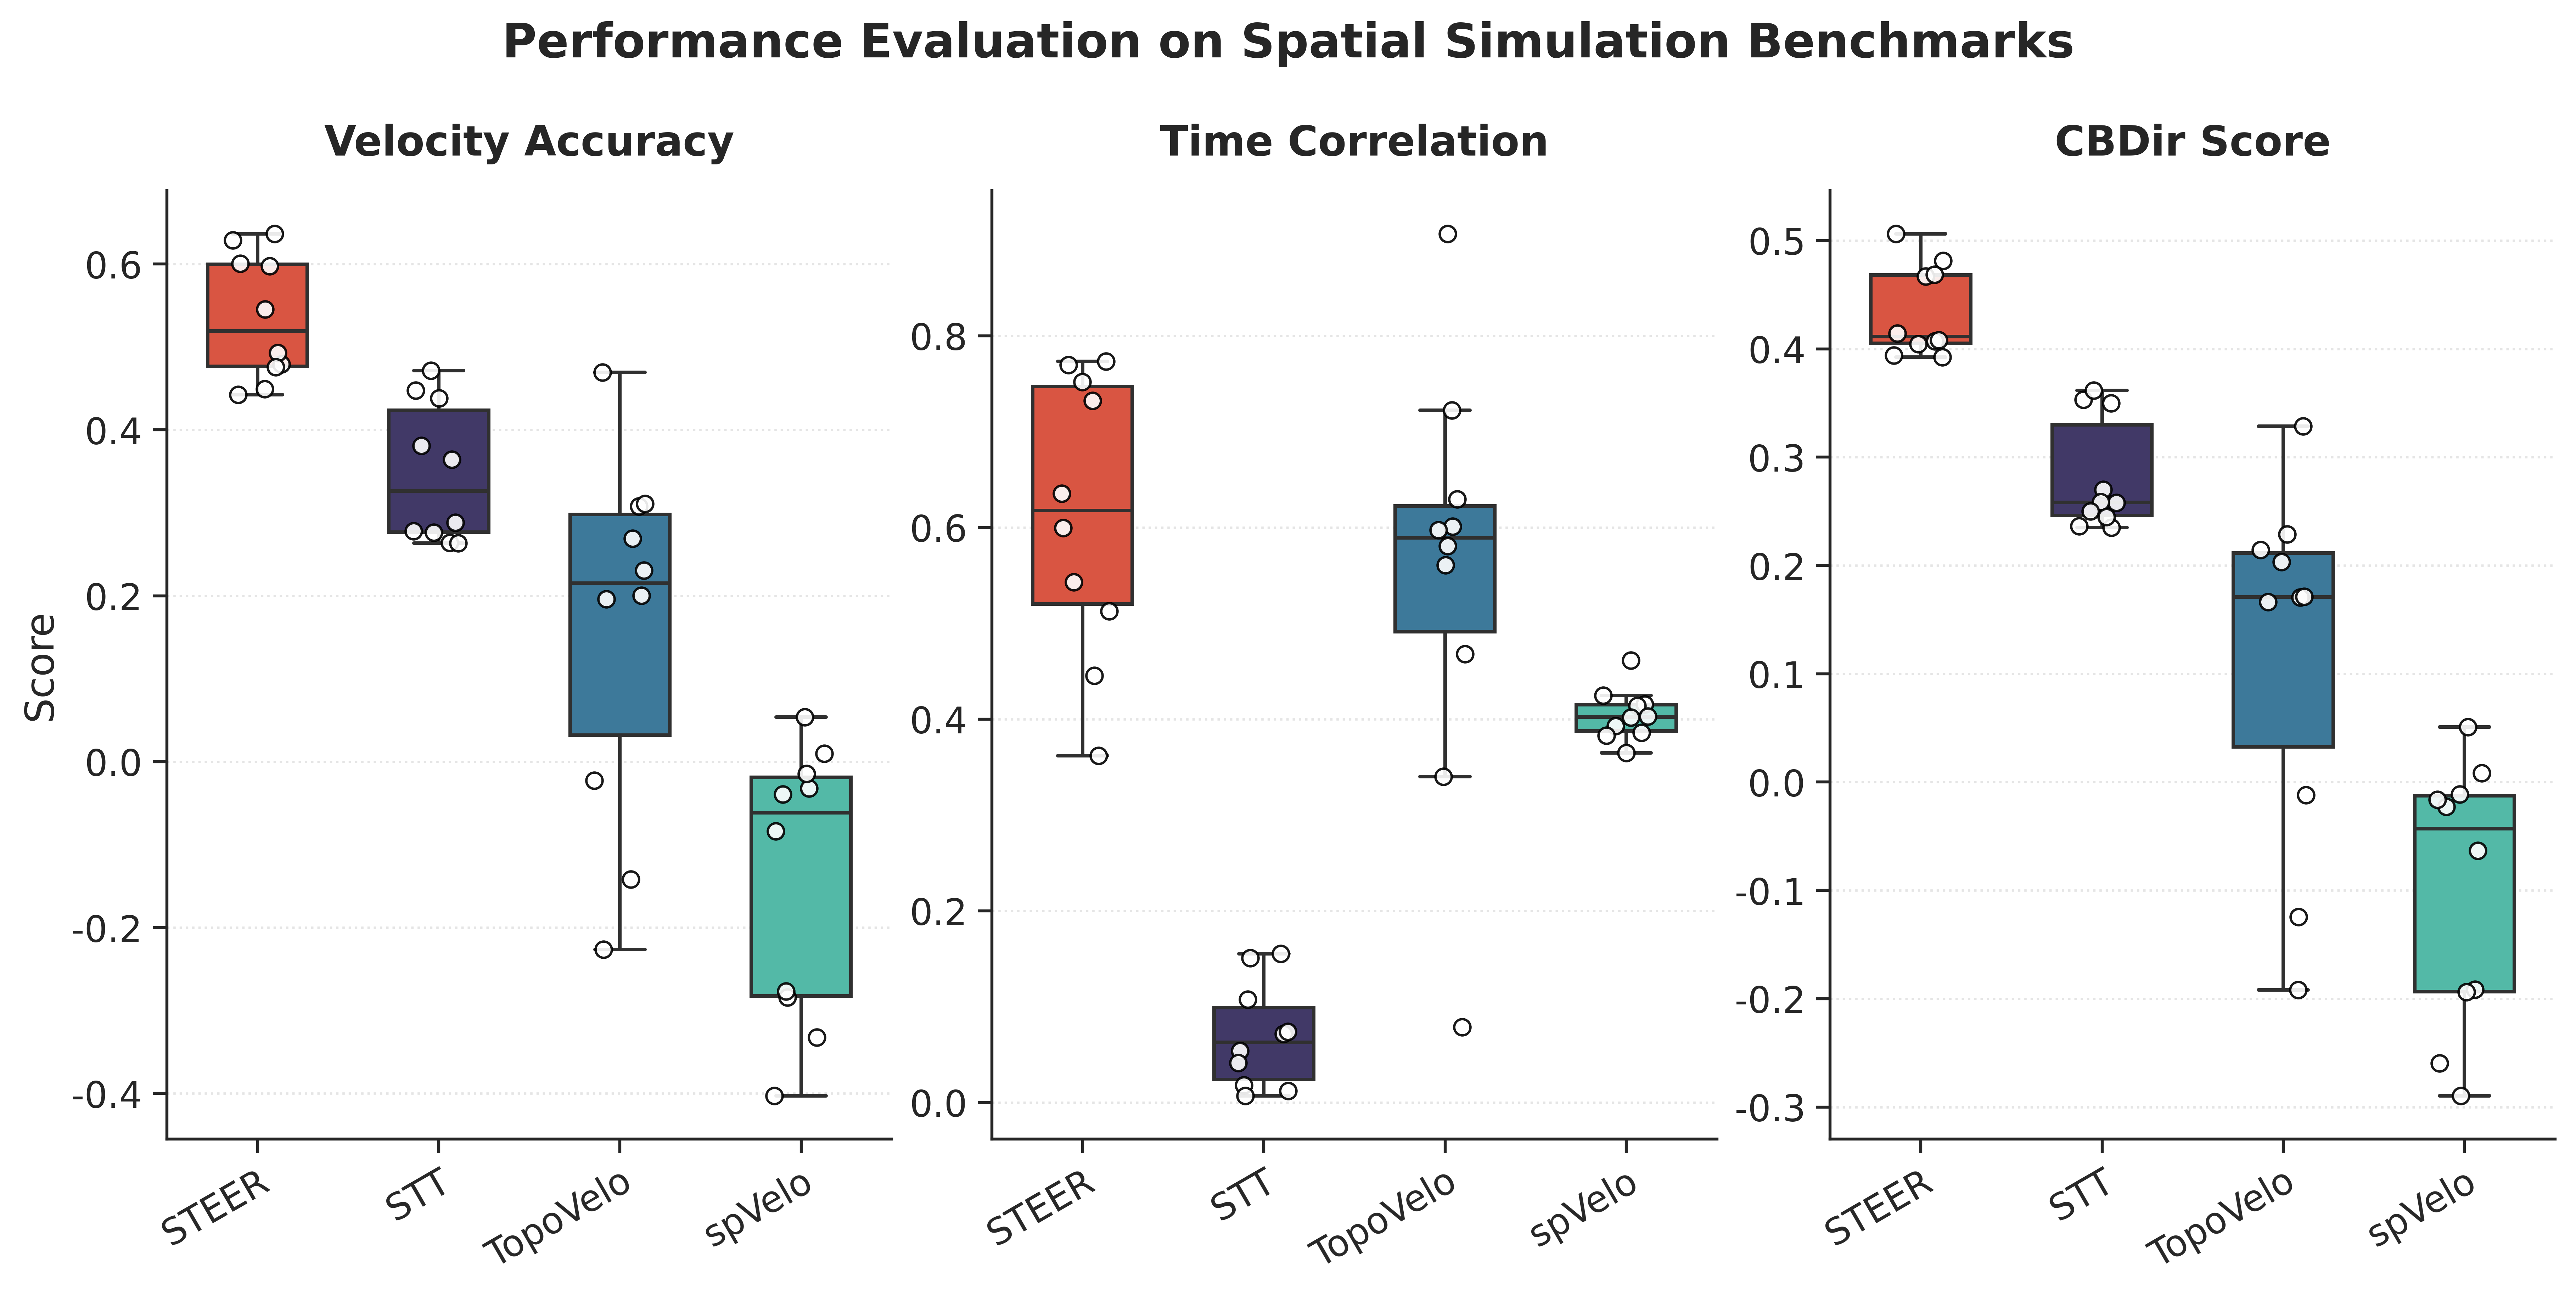

✅ Figure saved successfully to: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Results_Figure2/Fig_Simulation_Global_Boxplot.pdf


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 1. Configuration & File Paths
# ==============================================================================
BASE_DIR = '/nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures'
DATA_DIR = os.path.join(BASE_DIR, 'Data4NoteBook')
RESULT_DIR = os.path.join(BASE_DIR, 'Results_Figure2')
os.makedirs(RESULT_DIR, exist_ok=True)

FILE_MAIN = os.path.join(DATA_DIR, 'Figure2_spatial_simu_VelocityTime.csv')
FILE_CBDIR = os.path.join(DATA_DIR, 'Figure2_spatial_simu_CBDir.csv')

# ==============================================================================
# 2. Method Names Mapping & Plotting Settings
# ==============================================================================
NAME_MAPPING = {
    'STEER': 'STEER',
    'STT': 'STT',
    'TOPOVELO': 'TopoVelo',
    'SPVELO': 'spVelo'
}
DISPLAY_ORDER = ['STEER', 'STT', 'TopoVelo', 'spVelo']

METRICS = ['2D Velocity Accuracy', 'Time Correlation', 'CBDir']
METRIC_TITLES = {
    '2D Velocity Accuracy': 'Velocity Accuracy',
    'Time Correlation': 'Time Correlation',
    'CBDir': 'CBDir Score'
}

# ==============================================================================
# 3. Data Loading & Merging
# ==============================================================================
print("Loading and merging cleaned benchmark data...")
df_main = pd.read_csv(FILE_MAIN)
df_cbdir = pd.read_csv(FILE_CBDIR)


df_all = pd.merge(
    df_main, 
    df_cbdir[['Dataset', 'Method', 'CBDir']], 
    on=['Dataset', 'Method'], 
    how='left'
)

df_all['Method'] = df_all['Method'].map(NAME_MAPPING)

# ==============================================================================
# 4. Global Plotting Setup
# ==============================================================================
print("Generating Publication Figures...")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sns.set_theme(style="ticks", context="paper", font_scale=1.4)

NPG_RED = "#E64B35"
num_competitors = len(DISPLAY_ORDER) - 1
mako_palette = sns.color_palette("mako", n_colors=num_competitors)

mako_iter = iter(mako_palette)
color_dict = {method: (NPG_RED if method == 'STEER' else next(mako_iter)) for method in DISPLAY_ORDER}

# ==============================================================================
# 5. Execute Plotting
# ==============================================================================
fig, axes = plt.subplots(1, 3, figsize=(12, 5.5), constrained_layout=True)

fig.suptitle(
    'Performance Evaluation on Spatial Simulation Benchmarks', 
    fontsize=16, 
    fontweight='bold', 
    y=1.08 
)

for i, metric in enumerate(METRICS):
    ax = axes[i]
    if metric in df_all.columns:
        # Boxplot
        sns.boxplot(
            data=df_all, x='Method', y=metric,
            order=DISPLAY_ORDER, palette=color_dict, ax=ax,
            width=0.55, linewidth=1.2, fliersize=0, showmeans=False, saturation=0.85, zorder=3
        )
        
        # Stripplot 
        sns.stripplot(
            data=df_all, x='Method', y=metric,
            order=DISPLAY_ORDER, ax=ax,
            color='white', edgecolor='black', linewidth=0.8, size=5.5, jitter=0.15, alpha=0.9, zorder=10
        )
        
        ax.set_title(METRIC_TITLES.get(metric, metric), fontsize=14, fontweight='bold', pad=12)
        ax.set_xlabel('')
        ax.set_ylabel('Score' if i == 0 else '') 
        ax.grid(True, axis='y', linestyle=':', alpha=0.5, zorder=0)
        sns.despine(ax=ax)
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    else:
        ax.axis('off')

save_path_pdf = os.path.join(RESULT_DIR, 'Fig_Simulation_Global_Boxplot.pdf')
plt.savefig(save_path_pdf, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Figure saved successfully to: {save_path_pdf}")